In [ ]:
%pip install nltk transformers torch annoy seaborn matplotlib scikit-learn umap-learn

In [102]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from annoy import AnnoyIndex

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aayushgupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aayushgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [103]:
#LOADING THE FILE TEXT IN


# Define the file path
file_path = '/Users/aayushgupta/Downloads/James Green.txt'

# Read the content of the file
with open(file_path, 'r', encoding='utf-8') as file:
    document = file.read()


In [104]:
#PREPROCESSING THE TEXT

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


In [105]:
#SEGMENTING THE DOCUMENT

#This is for sentance
segments = sent_tokenize(document)


# from nltk.tokenize import word_tokenize

# # Replace sentence segmentation with word tokenization
# words = word_tokenize(document)


In [106]:
#EMBEDDING THE TEXT

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

embeddings = [embed_text(preprocess_text(seg)) for seg in segments]
embeddings = np.array(embeddings).squeeze()


In [109]:
#DOING THE QUERYING 

# Check the first embedding's shape
print(embeddings[0].shape)

# If the shape is not (embedding_size,), then adjust the embeddings
embeddings = [e[0] if len(e.shape) > 1 else e for e in embeddings]

f = embeddings[0].shape[0]  # The embedding size
t = AnnoyIndex(f, 'angular')

for i, vec in enumerate(embeddings):
    t.add_item(i, vec)

t.build(10)
t.save('test.ann')

def search(query, index, top_n=10):
    query_embedding = embed_text(preprocess_text(query))
    query_embedding = query_embedding[0] if len(query_embedding.shape) > 1 else query_embedding
    indices = index.get_nns_by_vector(query_embedding, top_n)
    return [segments[i] for i in indices]


u = AnnoyIndex(f, 'angular')
u.load('test.ann')

search_results = search("Value Innovation Purpose", u, top_n=5)
for result in search_results:
    print(result)


(768,)
Value curves are the tool for developing and delivering value innovation.
Overall, reducing factors can be a valuable strategy for entrepreneurs seeking to create value innovation.
In addition, value innovation can help entrepreneurs identify new opportunities and markets.
By examining these value curves, entrepreneurs can identify opportunities to create value and stand out from the competition.
The value curve is an essential tool for entrepreneurs looking to develop and deliver value innovation.


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 377 samples in 0.000s...
[t-SNE] Computed neighbors for 377 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 377 / 377
[t-SNE] Mean sigma: 1.990692
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.308235
[t-SNE] KL divergence after 300 iterations: 1.030503


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


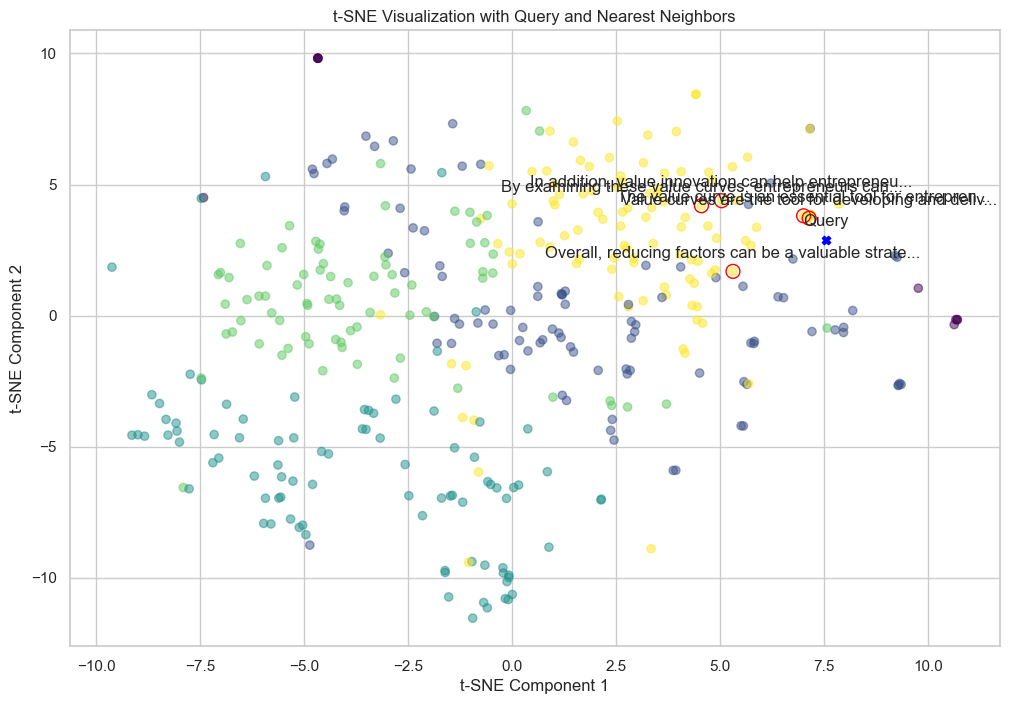

In [110]:
# PLOTTING 

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from annoy import AnnoyIndex

# Function to embed text, search, and plot
def search_and_plot(query, index, embeddings, segments, top_n=5):
    # Embed the query
    query_embedding = embed_text(preprocess_text(query))[0]
    extended_embeddings = np.append(embeddings, [query_embedding], axis=0)

    # Recalculate t-SNE for extended embeddings
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    extended_tsne_results = tsne.fit_transform(extended_embeddings)

    # KMeans clustering on extended embeddings
    kmeans = KMeans(n_clusters=5)
    clusters = kmeans.fit_predict(extended_embeddings)

    # Find nearest neighbors of the query
    indices = index.get_nns_by_vector(query_embedding, top_n)

    # Plotting
    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 8))

    # Plot all points with cluster coloring
    plt.scatter(extended_tsne_results[:-1, 0], extended_tsne_results[:-1, 1], c=clusters[:-1], alpha=0.5, cmap='viridis')

    # Highlight the query point
    plt.scatter(extended_tsne_results[-1, 0], extended_tsne_results[-1, 1], color='blue', marker='X')

    # Highlight nearest neighbors with red outline
    for i in indices:
        plt.scatter(extended_tsne_results[i, 0], extended_tsne_results[i, 1], facecolors='none', edgecolors='red', s=100)
        plt.annotate(
            segments[i][:50] + '...' if len(segments[i]) > 50 else segments[i],
            (extended_tsne_results[i, 0], extended_tsne_results[i, 1]),
            textcoords="offset points",
            xytext=(0,10),
            ha='center'
        )

    # Label the query
    plt.annotate("Query", (extended_tsne_results[-1, 0], extended_tsne_results[-1, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('t-SNE Visualization with Query and Nearest Neighbors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Define and load the Annoy index
f = embeddings[0].shape[0]
u = AnnoyIndex(f, 'angular')
u.load('test.ann')  # Assuming 'test.ann' is your pre-built Annoy index file

# Example usage
search_query = "Value Innovation Purpose"
search_and_plot(search_query, u, embeddings, segments, top_n=5)
